In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "layers": hp.choice('layers', [[64, 128, 64], [128, 256, 128], [256, 512, 256]]),
    "kss": hp.choice('kss', [[11, 9, 7], [9, 7, 5], [7, 5, 3]])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x230eb9d42c8>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x230eb9d4908>,
 'lr': <hyperopt.pyll.base.Apply at 0x230eb9c5088>,
 'epochs': <hyperopt.pyll.base.Apply at 0x230eb9c5688>,
 'patience': <hyperopt.pyll.base.Apply at 0x230eb9c5a88>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x230eb9c90c8>,
 'layers': <hyperopt.pyll.base.Apply at 0x230eb9c9e88>,
 'kss': <hyperopt.pyll.base.Apply at 0x230eb9ccbc8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = FCN
        k = {
            'layers': params['layers'],
            'kss': params['kss']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.01, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 60}
FCN                                                                                                                    
  0%|                                                                           | 0/30 [00:29<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,0.915888,0.990946,0.617200,00:14
1,0.862583,0.970873,0.668308,00:13
2,0.755419,1.023772,0.650500,00:13
3,0.641929,1.225623,0.652044,00:13
4,0.533115,1.276353,0.624342,00:13
5,0.445059,1.406763,0.646976,00:13
6,0.356781,1.746283,0.647893,00:13


No improvement since epoch 1: early stopping                                                                           
  0%|                                                                           | 0/30 [02:04<?, ?trial/s, best loss=?]

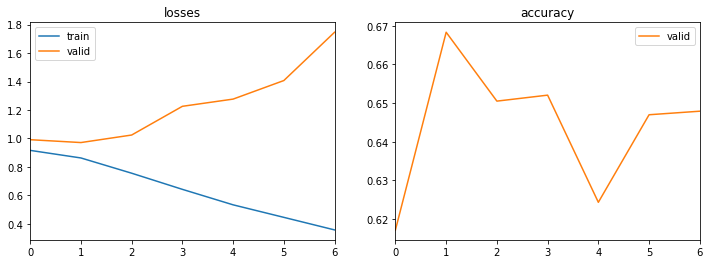

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.01, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
  3%|█▌                                            | 1/30 [02:31<1:00:15, 124.69s/trial, best loss: 1.7462828159332275]

epoch,train_loss,valid_loss,accuracy,time
0,0.838100,0.828186,0.687081,00:07
1,0.777685,0.826407,0.687612,00:07
2,0.707487,1.086146,0.679070,00:07
3,0.665840,1.144827,0.551277,00:07
4,0.621581,0.945561,0.686984,00:07
5,0.577436,1.181420,0.613001,00:07
6,0.557225,1.436770,0.674774,00:07


No improvement since epoch 1: early stopping                                                                           
  3%|█▌                                            | 1/30 [03:25<1:00:15, 124.69s/trial, best loss: 1.7462828159332275]

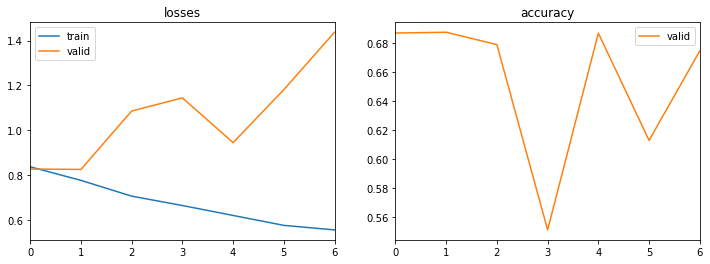

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.1, 'optimizer': <function SGD at 0x00000230AB86C1F8>, 'patience': 10, 'time_steps': 90}
FCN                                                                                                                    
  7%|███▏                                            | 2/30 [03:54<52:04, 111.60s/trial, best loss: 1.4367704391479492]

epoch,train_loss,valid_loss,accuracy,time
0,1.065696,1.072269,0.663047,00:17
1,1.002968,1.022927,0.658462,00:16
2,0.962054,0.982151,0.654457,00:16
3,0.933820,0.954511,0.656725,00:17
4,0.918722,0.936072,0.660731,00:17
5,0.901936,0.909479,0.670576,00:17
6,0.887845,0.907535,0.675836,00:17
7,0.877520,0.878344,0.680373,00:17
8,0.862119,0.877006,0.683606,00:17
9,0.855700,0.904415,0.669659,00:17


No improvement since epoch 12: early stopping                                                                          
  7%|███▏                                            | 2/30 [10:30<52:04, 111.60s/trial, best loss: 1.4367704391479492]

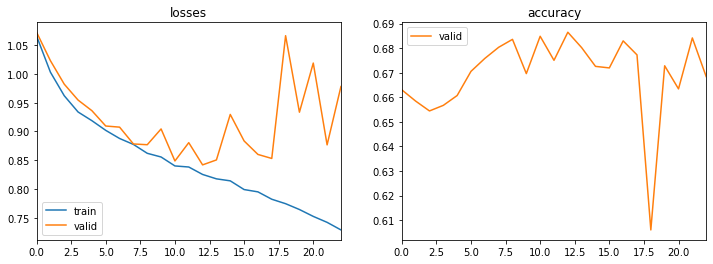

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.01, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 60}
FCN                                                                                                                    
 10%|████▌                                         | 3/30 [10:58<1:32:27, 205.48s/trial, best loss: 0.9779992699623108]

epoch,train_loss,valid_loss,accuracy,time
0,0.938438,0.909303,0.673278,00:12
1,0.869144,0.977445,0.679600,00:12
2,0.823628,0.991309,0.654843,00:12
3,0.739793,1.248978,0.643647,00:13
4,0.668134,1.004233,0.660345,00:12
5,0.582495,1.051824,0.633367,00:12


No improvement since epoch 0: early stopping                                                                           
 10%|████▌                                         | 3/30 [12:15<1:32:27, 205.48s/trial, best loss: 0.9779992699623108]

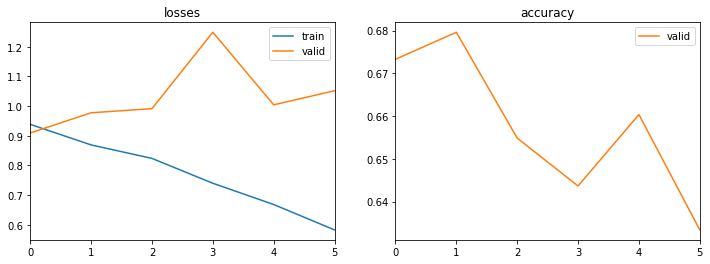

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 13%|██████▏                                       | 4/30 [12:47<1:16:03, 175.53s/trial, best loss: 0.9779992699623108]

epoch,train_loss,valid_loss,accuracy,time
0,1.540076,1.572874,0.555089,00:04
1,1.451169,1.490775,0.572801,00:04
2,1.357641,1.388946,0.591912,00:04
3,1.267926,1.272285,0.618358,00:04
4,1.178498,1.181265,0.633319,00:04
5,1.093758,1.099642,0.646349,00:04
6,1.017197,1.024426,0.654216,00:04
7,0.959053,0.973105,0.658269,00:04
8,0.926212,0.954772,0.661261,00:04
9,0.906063,0.937485,0.665364,00:04


No improvement since epoch 17: early stopping                                                                          
 13%|██████▏                                       | 4/30 [14:30<1:16:03, 175.53s/trial, best loss: 0.9779992699623108]

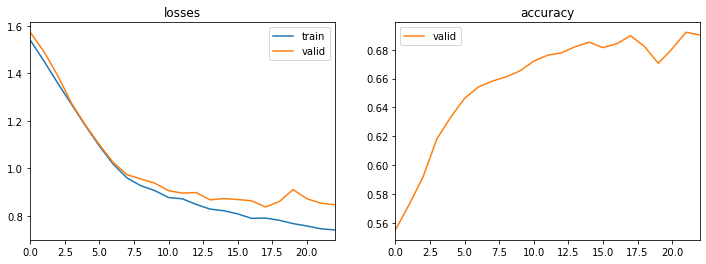

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'kss': (11, 9, 7), 'layers': (256, 512, 256), 'lr': 0.1, 'optimizer': <function SGD at 0x00000230AB86C1F8>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 17%|███████▋                                      | 5/30 [15:03<1:08:06, 163.46s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.048012,1.052975,0.660489,00:17
1,0.975771,1.000678,0.655036,00:18
2,0.929164,0.954834,0.659765,00:19
3,0.900619,0.904564,0.668983,00:19
4,0.881806,0.958218,0.640510,00:18
5,0.868930,0.851855,0.685102,00:17
6,0.847223,0.849545,0.685295,00:18
7,0.840174,0.916211,0.660538,00:18
8,0.824083,0.958520,0.640510,00:18
9,0.819426,0.944561,0.660007,00:18


No improvement since epoch 6: early stopping                                                                           
 17%|███████▋                                      | 5/30 [18:47<1:08:06, 163.46s/trial, best loss: 0.8464860320091248]

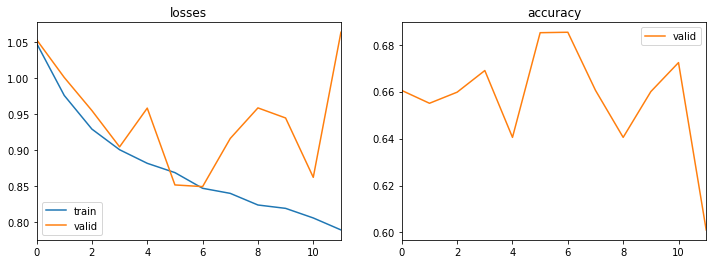

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 10, 'time_steps': 60}
FCN                                                                                                                    
 20%|█████████▏                                    | 6/30 [19:16<1:16:30, 191.27s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.442507,1.434698,0.575648,00:13
1,0.994353,0.944364,0.661213,00:13
2,0.884093,0.916579,0.668742,00:13
3,0.848721,0.894803,0.674919,00:13
4,0.813820,0.884566,0.683316,00:13
5,0.795321,0.877481,0.682930,00:13
6,0.774567,0.879270,0.680421,00:13
7,0.756293,0.857686,0.687322,00:13
8,0.749476,0.877715,0.681965,00:13
9,0.747987,0.871531,0.684233,00:13


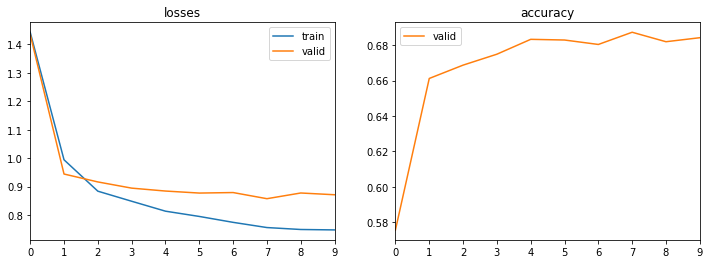

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'kss': (9, 7, 5), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 10, 'time_steps': 60}
FCN                                                                                                                    
 23%|██████████▋                                   | 7/30 [21:54<1:09:56, 182.47s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.605633,1.633749,0.497225,00:05
1,1.456012,1.501105,0.548429,00:04
2,1.295388,1.330564,0.590464,00:04
3,1.148440,1.146420,0.635298,00:05
4,1.020422,1.037382,0.649390,00:04
5,0.947521,0.948538,0.660103,00:05
6,0.913268,0.911565,0.668838,00:04
7,0.876922,0.904329,0.674678,00:05
8,0.867833,0.907391,0.676850,00:05
9,0.846625,0.878652,0.679793,00:05


No improvement since epoch 11: early stopping                                                                          
 23%|██████████▋                                   | 7/30 [23:45<1:09:56, 182.47s/trial, best loss: 0.8464860320091248]

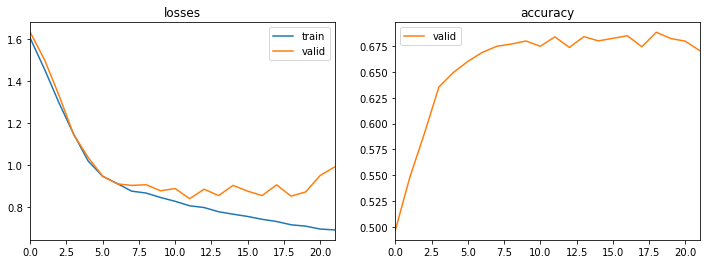

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'kss': (7, 5, 3), 'layers': (256, 512, 256), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 27%|████████████▎                                 | 8/30 [24:10<1:01:49, 168.60s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.516178,1.536870,0.554848,00:14
1,1.370913,1.392635,0.586796,00:14
2,1.248124,1.252791,0.612905,00:15
3,1.134129,1.123940,0.634670,00:15
4,1.040789,1.035644,0.643743,00:15
5,0.977702,0.972892,0.653781,00:15
6,0.929465,0.930141,0.664012,00:15
7,0.901749,0.920904,0.669466,00:15
8,0.884621,0.894475,0.675305,00:15
9,0.866029,0.865325,0.678153,00:15


No improvement since epoch 10: early stopping                                                                          
 27%|████████████▎                                 | 8/30 [28:24<1:01:49, 168.60s/trial, best loss: 0.8464860320091248]

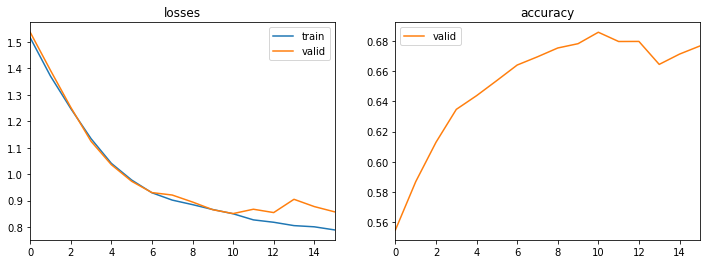

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'kss': (7, 5, 3), 'layers': (128, 256, 128), 'lr': 0.1, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 30%|█████████████▊                                | 9/30 [28:52<1:10:36, 201.75s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,0.879565,0.848391,0.691810,00:05
1,0.815592,0.916305,0.663675,00:05
2,0.766859,0.900396,0.651127,00:05
3,0.709857,1.197519,0.671493,00:05
4,0.666195,1.142422,0.651416,00:05
5,0.627666,1.067508,0.631002,00:05


No improvement since epoch 0: early stopping                                                                           
 30%|█████████████▊                                | 9/30 [29:24<1:10:36, 201.75s/trial, best loss: 0.8464860320091248]

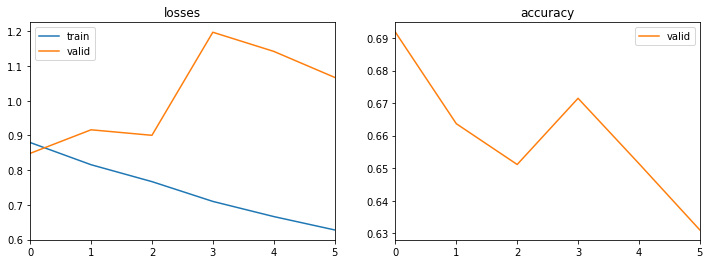

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.0001, 'optimizer': <function SGD at 0x00000230AB86C1F8>, 'patience': 10, 'time_steps': 90}
FCN                                                                                                                    
 33%|███████████████▋                               | 10/30 [29:49<53:04, 159.22s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.790151,1.790872,0.111771,00:17
1,1.733409,1.704034,0.395251,00:17
2,1.633643,1.590814,0.663675,00:17
3,1.540394,1.500229,0.664543,00:17
4,1.468329,1.434954,0.664543,00:17
5,1.416689,1.392189,0.664543,00:17
6,1.386302,1.366380,0.664543,00:18
7,1.368336,1.352104,0.664543,00:18
8,1.361412,1.347009,0.664543,00:18
9,1.357770,1.346338,0.664543,00:18


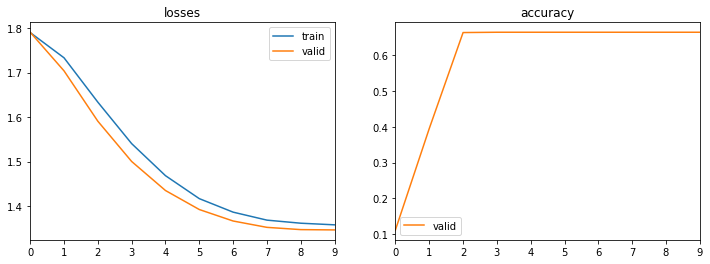

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'kss': (7, 5, 3), 'layers': (256, 512, 256), 'lr': 0.001, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 37%|█████████████████▏                             | 11/30 [33:13<54:35, 172.38s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,0.955512,0.939881,0.663481,00:15
1,0.875613,0.887164,0.673664,00:16
2,0.818074,0.815713,0.689494,00:16
3,0.798659,0.871899,0.684716,00:16
4,0.758287,0.906331,0.673809,00:17
5,0.728311,0.854497,0.688191,00:17
6,0.688219,0.917399,0.668983,00:17
7,0.661977,1.164682,0.678539,00:17


No improvement since epoch 2: early stopping                                                                           
 37%|█████████████████▏                             | 11/30 [35:27<54:35, 172.38s/trial, best loss: 0.8464860320091248]

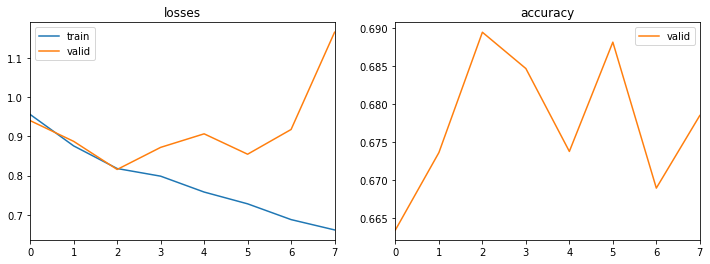

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'kss': (11, 9, 7), 'layers': (256, 512, 256), 'lr': 0.1, 'optimizer': <function SGD at 0x00000230AB86C1F8>, 'patience': 5, 'time_steps': 30}
FCN                                                                                                                    
 40%|██████████████████▊                            | 12/30 [35:53<50:38, 168.79s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.125140,1.083556,0.663675,00:07
1,1.040903,1.042392,0.659042,00:07
2,0.998299,1.019890,0.654167,00:07
3,0.974483,0.998292,0.653250,00:07
4,0.958195,0.978999,0.660538,00:07
5,0.941867,0.971021,0.657642,00:07
6,0.935492,0.952702,0.668211,00:07
7,0.923365,0.965668,0.665605,00:07
8,0.920307,0.938075,0.676705,00:07
9,0.908876,0.956513,0.674147,00:07


No improvement since epoch 14: early stopping                                                                          
 40%|██████████████████▊                            | 12/30 [38:30<50:38, 168.79s/trial, best loss: 0.8464860320091248]

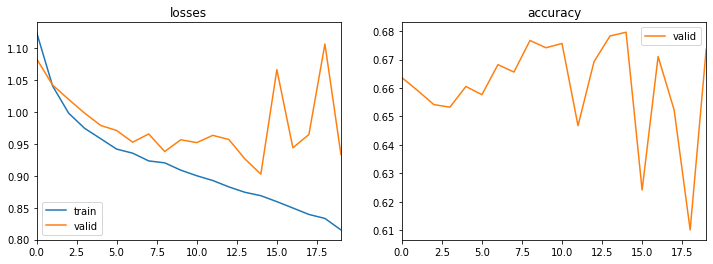

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.01, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 43%|████████████████████▎                          | 13/30 [38:55<48:58, 172.87s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,0.834558,0.885623,0.677284,00:18
1,0.748925,0.924251,0.687901,00:19
2,0.692592,0.911864,0.686888,00:20
3,0.645056,1.101504,0.682737,00:20
4,0.618821,1.023331,0.619565,00:20
5,0.577917,1.284672,0.672410,00:20


No improvement since epoch 0: early stopping                                                                           
 43%|████████████████████▎                          | 13/30 [40:56<48:58, 172.87s/trial, best loss: 0.8464860320091248]

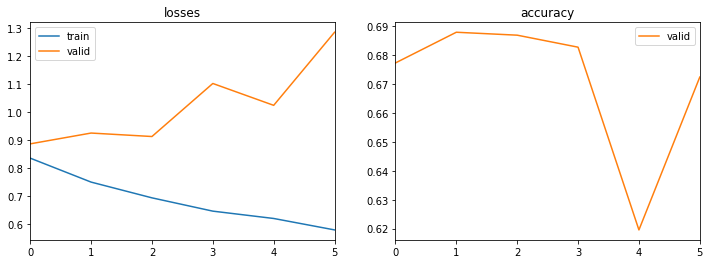

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'kss': (9, 7, 5), 'layers': (64, 128, 64), 'lr': 0.001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 60}
FCN                                                                                                                    
 47%|█████████████████████▉                         | 14/30 [41:21<43:56, 164.81s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.156712,1.149971,0.632885,00:03
1,0.954639,0.967182,0.661889,00:03
2,0.898174,0.914216,0.674437,00:03
3,0.866470,0.873838,0.682641,00:03
4,0.844235,0.898529,0.666715,00:03
5,0.833007,0.893241,0.672989,00:03
6,0.814524,0.878380,0.686309,00:03
7,0.788023,0.939432,0.661841,00:03
8,0.753626,0.918927,0.679070,00:03


No improvement since epoch 3: early stopping                                                                           
 47%|█████████████████████▉                         | 14/30 [41:50<43:56, 164.81s/trial, best loss: 0.8464860320091248]

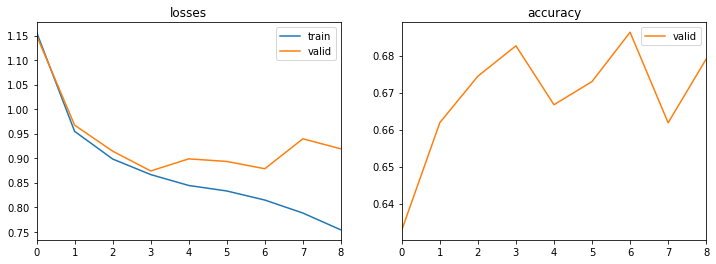

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.1, 'optimizer': <function SGD at 0x00000230AB86C1F8>, 'patience': 10, 'time_steps': 60}
FCN                                                                                                                    
 50%|███████████████████████▌                       | 15/30 [42:15<32:54, 131.64s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,0.993082,0.976978,0.658462,00:12
1,0.917009,1.093169,0.609382,00:13
2,0.883714,0.881242,0.673278,00:13
3,0.864672,0.891224,0.669707,00:13
4,0.850298,0.907178,0.664061,00:13
5,0.830544,0.868676,0.679214,00:13
6,0.810721,0.939313,0.654023,00:13
7,0.797243,0.883356,0.674292,00:13
8,0.785853,0.860431,0.679842,00:13
9,0.785698,0.864603,0.678297,00:14


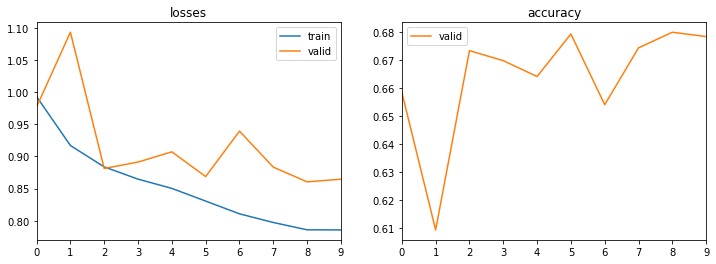

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (9, 7, 5), 'layers': (256, 512, 256), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 30}
FCN                                                                                                                    
 53%|█████████████████████████                      | 16/30 [44:56<32:46, 140.45s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.344126,1.385178,0.579702,00:08
1,1.176654,1.188718,0.617007,00:08
2,1.062378,1.077321,0.639255,00:08
3,0.990441,0.995375,0.656242,00:08
4,0.948460,0.966698,0.663385,00:08
5,0.926338,0.956373,0.667921,00:08
6,0.919431,0.949970,0.669176,00:08
7,0.891546,0.938908,0.673471,00:08
8,0.881760,0.927750,0.677863,00:08
9,0.863611,0.947478,0.673278,00:08


No improvement since epoch 8: early stopping                                                                           
 53%|█████████████████████████                      | 16/30 [46:52<32:46, 140.45s/trial, best loss: 0.8464860320091248]

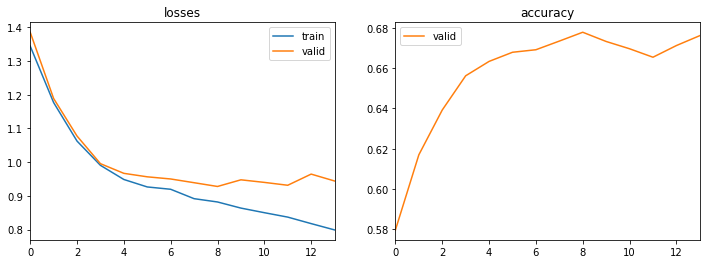

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'kss': (9, 7, 5), 'layers': (64, 128, 64), 'lr': 0.001, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 60}
FCN                                                                                                                    
 57%|██████████████████████████▋                    | 17/30 [47:17<30:28, 140.65s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.335761,1.201417,0.623860,00:02
1,0.920557,0.902387,0.678587,00:02
2,0.859407,0.908477,0.675788,00:02
3,0.815050,0.902616,0.680035,00:02
4,0.772287,0.918940,0.679649,00:02
5,0.738165,0.907101,0.672168,00:02
6,0.717253,0.918053,0.680807,00:02


No improvement since epoch 1: early stopping                                                                           
 57%|██████████████████████████▋                    | 17/30 [47:33<30:28, 140.65s/trial, best loss: 0.8464860320091248]

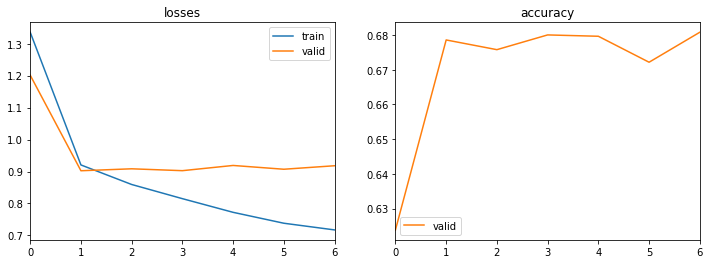

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'kss': (11, 9, 7), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 10, 'time_steps': 30}
FCN                                                                                                                    
 60%|████████████████████████████▏                  | 18/30 [47:58<22:10, 110.84s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.606300,1.638413,0.445828,00:03
1,1.462221,1.498979,0.539839,00:02
2,1.304913,1.326775,0.588003,00:02
3,1.152821,1.146972,0.630906,00:02
4,1.025819,1.036010,0.656773,00:02
5,0.967912,0.971723,0.664978,00:02
6,0.937683,0.950034,0.667873,00:02
7,0.917186,0.933547,0.674195,00:03
8,0.914010,0.940793,0.673375,00:02
9,0.888064,0.964323,0.668694,00:02


No improvement since epoch 11: early stopping                                                                          
 60%|████████████████████████████▏                  | 18/30 [49:04<22:10, 110.84s/trial, best loss: 0.8464860320091248]

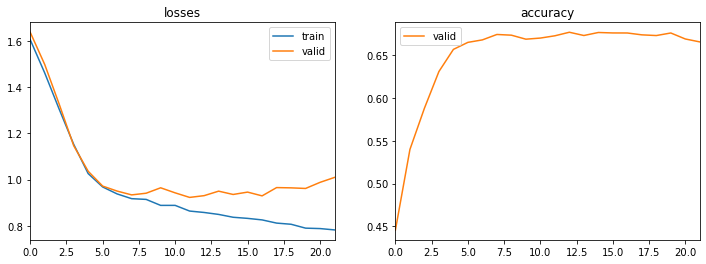

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function Adam at 0x00000230AB86C558>, 'patience': 5, 'time_steps': 60}
FCN                                                                                                                    
 63%|█████████████████████████████▊                 | 19/30 [49:29<19:11, 104.72s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.782764,1.823556,0.303122,00:05
1,1.679544,1.747241,0.458858,00:05
2,1.543108,1.606701,0.535785,00:05
3,1.401482,1.417228,0.581584,00:05
4,1.263700,1.261598,0.614642,00:05
5,1.141773,1.115710,0.637855,00:05
6,1.038986,1.023511,0.648424,00:05
7,0.962995,0.956642,0.667004,00:05
8,0.917112,0.914398,0.669418,00:05
9,0.886785,0.913639,0.673230,00:05


No improvement since epoch 20: early stopping                                                                          
 63%|█████████████████████████████▊                 | 19/30 [51:46<19:11, 104.72s/trial, best loss: 0.8464860320091248]

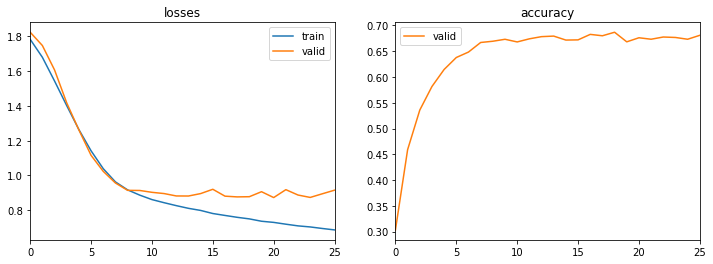

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'kss': (7, 5, 3), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 67%|███████████████████████████████▎               | 20/30 [52:12<20:20, 122.02s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.793024,1.820690,0.205589,00:02
1,1.735155,1.781138,0.378553,00:02
2,1.672130,1.717944,0.486173,00:02
3,1.602115,1.655622,0.522224,00:02
4,1.518337,1.576576,0.547609,00:02
5,1.429980,1.472888,0.577482,00:02
6,1.331568,1.358617,0.600502,00:02
7,1.231118,1.250334,0.616235,00:02
8,1.137552,1.157885,0.636214,00:02
9,1.056959,1.064571,0.647845,00:02


No improvement since epoch 34: early stopping                                                                          
 67%|███████████████████████████████▎               | 20/30 [53:52<20:20, 122.02s/trial, best loss: 0.8464860320091248]

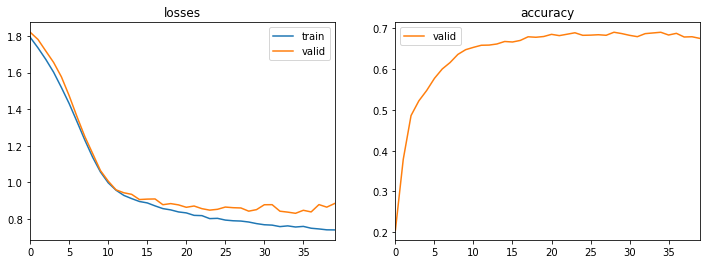

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (7, 5, 3), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 70%|████████████████████████████████▉              | 21/30 [54:17<18:27, 123.06s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.713433,1.741025,0.315767,00:03
1,1.625522,1.672239,0.471116,00:03
2,1.527686,1.580346,0.532793,00:03
3,1.427493,1.473184,0.567781,00:03
4,1.314170,1.340418,0.589354,00:03
5,1.190763,1.198676,0.616379,00:03
6,1.099715,1.069304,0.645577,00:03
7,1.005024,0.997712,0.653057,00:03
8,0.955227,0.960276,0.657352,00:03
9,0.933729,0.925487,0.662130,00:03


No improvement since epoch 22: early stopping                                                                          
 70%|████████████████████████████████▉              | 21/30 [55:50<18:27, 123.06s/trial, best loss: 0.8464860320091248]

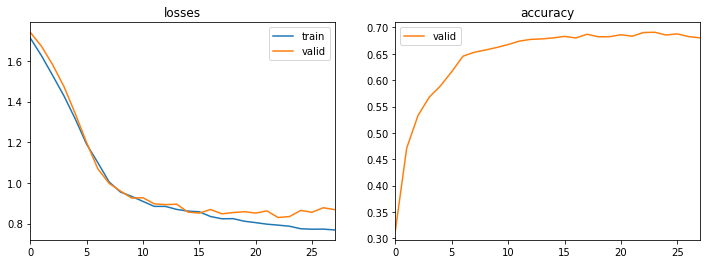

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'kss': (7, 5, 3), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 73%|██████████████████████████████████▍            | 22/30 [56:16<16:13, 121.66s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.814942,1.846543,0.112495,00:02
1,1.754849,1.800593,0.295304,00:02
2,1.691037,1.746384,0.466483,00:02
3,1.613355,1.672922,0.524203,00:02
4,1.526557,1.596528,0.548333,00:02
5,1.436732,1.476362,0.571015,00:02
6,1.337704,1.365235,0.590850,00:02
7,1.240632,1.247633,0.615173,00:02
8,1.147367,1.145419,0.632885,00:02
9,1.067352,1.070009,0.640365,00:02


No improvement since epoch 28: early stopping                                                                          
 73%|██████████████████████████████████▍            | 22/30 [57:40<16:13, 121.66s/trial, best loss: 0.8464860320091248]

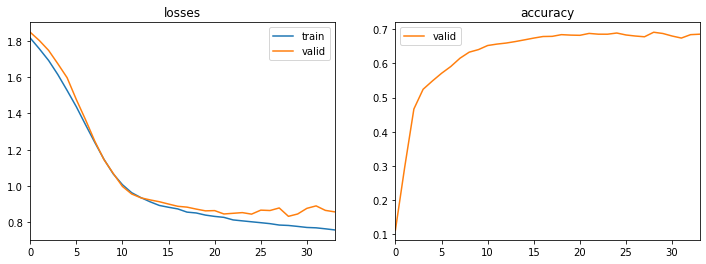

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (7, 5, 3), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 77%|████████████████████████████████████           | 23/30 [58:06<13:47, 118.26s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.459203,1.464733,0.618696,00:03
1,1.385383,1.407149,0.607210,00:03
2,1.314501,1.327857,0.608417,00:03
3,1.225280,1.236152,0.619130,00:03
4,1.139626,1.138669,0.644467,00:03
5,1.063599,1.053511,0.653395,00:03
6,1.003636,0.992024,0.655277,00:03
7,0.962532,0.954227,0.657883,00:03
8,0.936279,0.938423,0.658655,00:03
9,0.916538,0.919907,0.662034,00:03


No improvement since epoch 18: early stopping                                                                          
 77%|████████████████████████████████████           | 23/30 [59:25<13:47, 118.26s/trial, best loss: 0.8464860320091248]

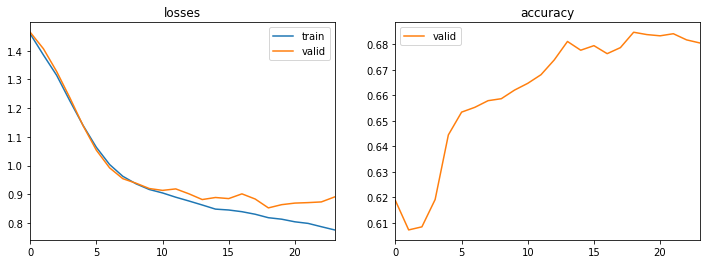

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (64, 128, 64), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 30}
FCN                                                                                                                    
 80%|█████████████████████████████████████▌         | 24/30 [59:50<11:25, 114.18s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.468505,1.481532,0.584673,00:02
1,1.392084,1.419715,0.580570,00:02
2,1.307083,1.342555,0.589064,00:02
3,1.236296,1.251400,0.603349,00:02
4,1.153248,1.168781,0.616524,00:02
5,1.084982,1.086361,0.641041,00:02
6,1.021453,1.031421,0.655760,00:02
7,0.977185,0.991562,0.661117,00:02
8,0.954990,0.968863,0.666281,00:02
9,0.946213,0.957115,0.668597,00:02


No improvement since epoch 15: early stopping                                                                          
 80%|████████████████████████████████████         | 24/30 [1:00:53<11:25, 114.18s/trial, best loss: 0.8464860320091248]

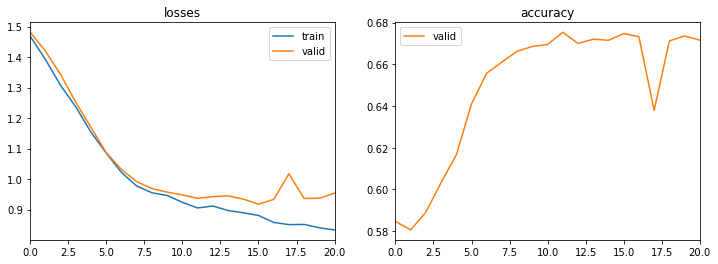

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'kss': (7, 5, 3), 'layers': (64, 128, 64), 'lr': 0.001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 83%|█████████████████████████████████████▌       | 25/30 [1:01:18<08:51, 106.22s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.409916,1.387618,0.579316,00:02
1,1.199855,1.164982,0.624246,00:02
2,1.053887,1.020748,0.651706,00:02
3,0.974142,0.964629,0.658173,00:02
4,0.915314,0.915435,0.667535,00:02
5,0.896082,0.886828,0.674002,00:02
6,0.868657,0.883523,0.677622,00:02
7,0.851443,0.866172,0.681000,00:02
8,0.837257,0.872979,0.673761,00:02
9,0.828887,0.906969,0.661841,00:02


No improvement since epoch 10: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [1:01:58<08:51, 106.22s/trial, best loss: 0.8464860320091248]

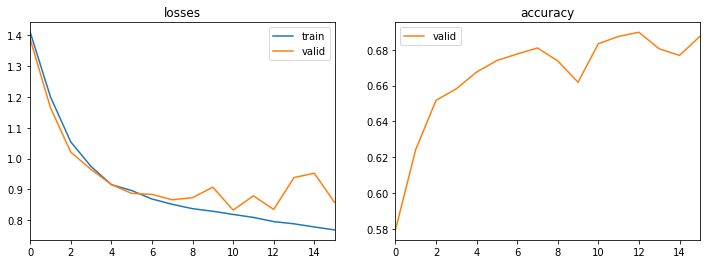

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 87%|███████████████████████████████████████▊      | 26/30 [1:02:23<06:15, 93.80s/trial, best loss: 0.8464860320091248]

epoch,train_loss,valid_loss,accuracy,time
0,1.515478,1.539701,0.530283,00:06
1,1.448907,1.497895,0.544954,00:06
2,1.390315,1.432785,0.560494,00:06
3,1.326724,1.360512,0.581198,00:06
4,1.262085,1.303190,0.597413,00:06
5,1.199338,1.194971,0.628879,00:06
6,1.131962,1.139133,0.640075,00:06
7,1.072128,1.075753,0.645867,00:06
8,1.016767,1.025024,0.652237,00:06
9,0.967722,0.976981,0.660682,00:06


No improvement since epoch 20: early stopping                                                                          
 87%|███████████████████████████████████████▊      | 26/30 [1:05:14<06:15, 93.80s/trial, best loss: 0.8464860320091248]

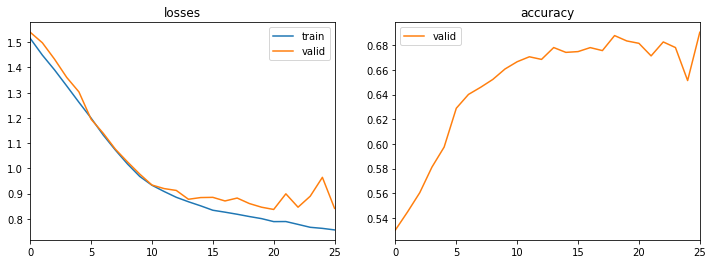

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN                                                                                                                    
 90%|████████████████████████████████████████▌    | 27/30 [1:05:40<06:14, 124.71s/trial, best loss: 0.8411968350410461]

epoch,train_loss,valid_loss,accuracy,time
0,1.455276,1.484168,0.568891,00:06
1,1.393429,1.428710,0.566913,00:06
2,1.335402,1.361395,0.581439,00:06
3,1.277355,1.290301,0.599054,00:06
4,1.219569,1.227266,0.615173,00:06
5,1.160759,1.180878,0.622991,00:06
6,1.103925,1.117463,0.638097,00:06
7,1.047494,1.068138,0.643936,00:06
8,0.999394,1.007738,0.653733,00:06
9,0.959751,0.966194,0.662130,00:06


No improvement since epoch 24: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [1:09:02<06:14, 124.71s/trial, best loss: 0.8411968350410461]

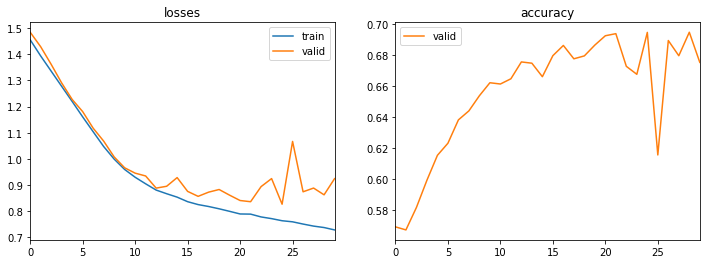

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.01, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 30}
FCN                                                                                                                    
 93%|██████████████████████████████████████████   | 28/30 [1:09:27<05:11, 155.54s/trial, best loss: 0.8411968350410461]

epoch,train_loss,valid_loss,accuracy,time
0,0.964266,0.947289,0.667342,00:03
1,0.918338,0.970149,0.660924,00:02
2,0.897453,0.947343,0.666522,00:02
3,0.880019,0.930016,0.677043,00:02
4,0.867251,1.015380,0.662082,00:02
5,0.859560,0.990494,0.668066,00:02
6,0.835738,1.061729,0.652382,00:02
7,0.843696,0.987475,0.668404,00:02
8,0.811960,1.208791,0.672796,00:02


No improvement since epoch 3: early stopping                                                                           
 93%|██████████████████████████████████████████   | 28/30 [1:09:53<05:11, 155.54s/trial, best loss: 0.8411968350410461]

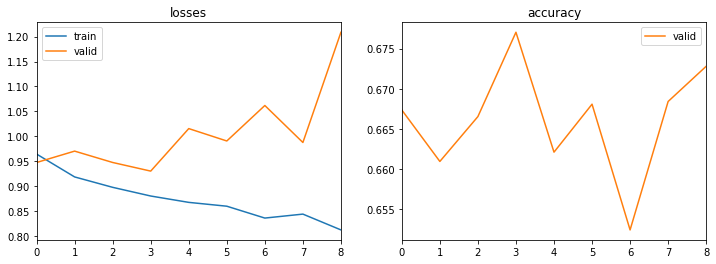

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 10, 'time_steps': 90}
FCN                                                                                                                    
 97%|███████████████████████████████████████████▌ | 29/30 [1:10:18<02:04, 124.13s/trial, best loss: 0.8411968350410461]

epoch,train_loss,valid_loss,accuracy,time
0,1.705548,1.735781,0.439361,00:06
1,1.621793,1.672427,0.512620,00:06
2,1.545817,1.614299,0.541673,00:06
3,1.468577,1.524760,0.569133,00:06
4,1.386710,1.428620,0.590222,00:06
5,1.302243,1.334534,0.606776,00:06
6,1.220239,1.248598,0.623474,00:06
7,1.143700,1.168374,0.631002,00:06
8,1.073537,1.072017,0.651079,00:06
9,1.012843,1.010267,0.657063,00:06


No improvement since epoch 30: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [1:14:58<02:04, 124.13s/trial, best loss: 0.8411968350410461]

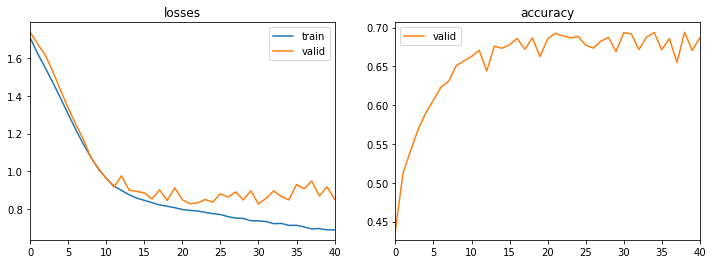

100%|█████████████████████████████████████████████| 30/30 [1:14:58<00:00, 149.95s/trial, best loss: 0.8411968350410461]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 2, 'epochs': 2, 'kss': 0, 'layers': 1, 'lr': 3, 'optimizer': 2, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 1024, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = FCN
    k = {
        'layers': params['layers'],
        'kss': params['kss']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 1024, 'epochs': 100, 'kss': (11, 9, 7), 'layers': (128, 256, 128), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x00000230AB86C318>, 'patience': 5, 'time_steps': 90}
FCN


epoch,train_loss,valid_loss,accuracy,time
0,1.658593,1.666369,0.480286,00:06
1,1.578643,1.609709,0.528112,00:06
2,1.503564,1.546081,0.550070,00:06
3,1.431937,1.472081,0.567637,00:06
4,1.356550,1.358275,0.593215,00:06
5,1.279110,1.274936,0.607548,00:06
6,1.203879,1.194267,0.624294,00:06
7,1.131812,1.121090,0.638869,00:06
8,1.066849,1.049103,0.653829,00:06
9,1.008753,0.999022,0.660875,00:06


No improvement since epoch 20: early stopping


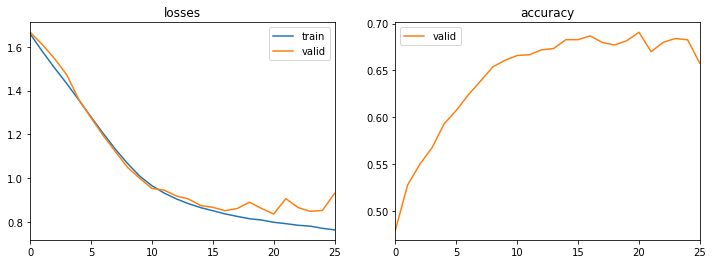

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[4.5097e-01, 3.0098e-01, 1.5604e-01, 7.5502e-02, 1.4709e-02, 1.8004e-03],
         [9.3791e-01, 5.1411e-02, 9.7897e-03, 7.2250e-04, 1.2447e-04, 4.4267e-05],
         [9.6061e-01, 2.8964e-02, 9.0441e-03, 1.2448e-03, 1.1131e-04, 2.2057e-05],
         ...,
         [9.9736e-01, 2.4764e-03, 1.4396e-04, 1.8777e-05, 3.7545e-06, 1.2880e-06],
         [9.9468e-01, 4.8665e-03, 4.0865e-04, 3.7077e-05, 8.5785e-06, 3.3073e-06],
         [9.4134e-01, 5.1676e-02, 5.7406e-03, 1.1048e-03, 1.1685e-04, 2.2396e-05]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.710768
f1 score:   0.696659


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_FCN', y_test_true)
np.save('y_pred_FCN', y_test_pred)